In [1]:
import os
import json

In [4]:
class LogReader:
    def __init__(self, log_dir):
        self.log_dir = log_dir
        self._read_files()
    
    def _read_files(self, ):
        files = os.listdir(self.log_dir)
        self.jsons = {}
        for f in files:
            if 'json' in f:
                self.jsons[f] = json.load(open(os.path.join(self.log_dir, f)))

l = LogReader('/mnt/text2sql/meta-prompter-log/schema-data-few-shot-random')

In [7]:
error_logs = []
for res in l.jsons['combined.json']:
    if not res['metrics']['executionMatch']:
        error_logs.append(res)
        print(res['index'])
        print("prompt: ", res['initialPredict']['prompt'])
        print("solution: ", res['solution'].replace('\n', ' '))        
        print("prediction: ", res['normalizeResult']['normalizedSolution'][0].replace('\n', ' '))
        print('################################')        

6
prompt:  The digital assistant is capable of translating a natural language question into a valid SQL query with correct syntax. The question is given with a corresponding (partial) database schema. The generated query must adhere to this schema.

The database schema is as follows:
---
Table 'artists'
Columns: 'id', 'name'
Table 'sqlite_sequence'
Columns: 'name', 'seq'
Table 'albums'
Columns: 'id', 'title', 'artist_id'
Table 'employees'
Columns: 'id', 'last_name', 'first_name', 'title', 'reports_to', 'birth_date', 'hire_date', 'address', 'city', 'state', 'country', 'postal_code', 'phone', 'fax', 'email'
Table 'customers'
Columns: 'id', 'first_name', 'last_name', 'company', 'address', 'city', 'state', 'country', 'postal_code', 'phone', 'fax', 'email', 'support_rep_id'
Table 'genres'
Columns: 'id', 'name'
Table 'invoices'
Columns: 'id', 'customer_id', 'invoice_date', 'billing_address', 'billing_city', 'billing_state', 'billing_country', 'billing_postal_code', 'total'
Table 'media_types

In [9]:
json.dump(error_logs, open('/mnt/text2sql/meta-prompter-log/schema-data-few-shot-random/erros.json', 'w'))

# Profiling the error

### how many times does GPT generate super set results of Spider

In [42]:
import sqlite3
schema_tables = []
sql_word_cnt = []
superset_cnt = 0
more_columns = []
execution_err = []

l = LogReader('/mnt/text2sql/meta-prompter-log/schema-data-zero-shot')
for idx, log in enumerate(error_logs):
    db_id = log['schema']['database']
    question = log['question']
    ground_truth_sql = log['solution']
    predicted_sql = log['normalizeResult']['normalizedSolution'][0]
    
    ##############################
    schema_tables.append(log['schema']['num_tables'])
    sql_word_cnt.append(len(ground_truth_sql.split(' ')))
    
    
    ###############################
    db_path = f'/mnt/text2sql/dataset/spider/database/{db_id}/{db_id}.sqlite'
    connection = sqlite3.connect(db_path)
    cursor = connection.cursor()
    
    try:
        groundtruth_results = cursor.execute(ground_truth_sql).fetchall()
        predicted_results = cursor.execute(predicted_sql).fetchall()

        if len(groundtruth_results) > 0 and len(predicted_results) > 0:
            col_nums = len(groundtruth_results[0])
            gt_column_sets = [[] for i in range(col_nums)]
            for row in groundtruth_results:
                for idx, cell in enumerate(row):
                    gt_column_sets[idx].append(cell)
            gt_column_sets = set([frozenset(i) for i in gt_column_sets])
            
            pred_column_sets = [[] for i in range(col_nums)]
            for row in groundtruth_results:
                for idx, cell in enumerate(row):
                    pred_column_sets[idx].append(cell)
            pred_column_sets = set([frozenset(i) for i in pred_column_sets])
            
            if gt_column_sets.issubset(pred_column_sets):
                more_columns.append(idx)
            
        # if len(res_pred) == 0:
        #     empty_results.append(idx)
        
    except Exception as e:
        print(e)
        execution_err.append(idx)
        # continue


no such column: horsepower
no such column: horsepower
no such column: weight
no such column: weight
no such column: YEAR
no such column: YEAR
no such column: make
no such column: maker
no such column: maker
ambiguous column name: model
ambiguous column name: model
no such column: car_names.modelid
no such column: weight
no such column: model
no such column: horsepower
no such column: car_names.make
no such column: destairport
no such column: level_of_membership
Could not decode to UTF-8 column 'last_name' with text 'Treyes Albarrac��N'
Could not decode to UTF-8 column 'last_name' with text 'Treyes Albarrac��N'
incomplete input
wrong number of arguments to function count()
no such column: height
no such column: height
no such column: continent
ambiguous column name: population
ambiguous column name: state
no such function: now
no such function: now
ambiguous column name: breed_code


In [43]:
len(execution_err)

30

In [ ]:
dict(sorted(error_logs.items(), key=lambda item: item[1]))

In [100]:
error_logs = sorted(error_logs, key = lambda item: len(item['solution']))

(array([42., 65., 47., 23., 14.,  0., 13.,  0.,  2.,  2.]),
 array([ 4. , 11.5, 19. , 26.5, 34. , 41.5, 49. , 56.5, 64. , 71.5, 79. ]),
 <BarContainer object of 10 artists>)

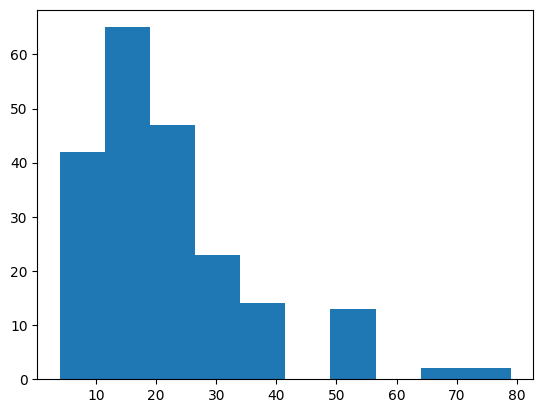

In [90]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(sql_word_cnt,)

(array([345., 372., 169.,  87.,  23.,   5.,  25.,   4.,   2.,   2.]),
 array([ 3. , 10.6, 18.2, 25.8, 33.4, 41. , 48.6, 56.2, 63.8, 71.4, 79. ]),
 <BarContainer object of 10 artists>)

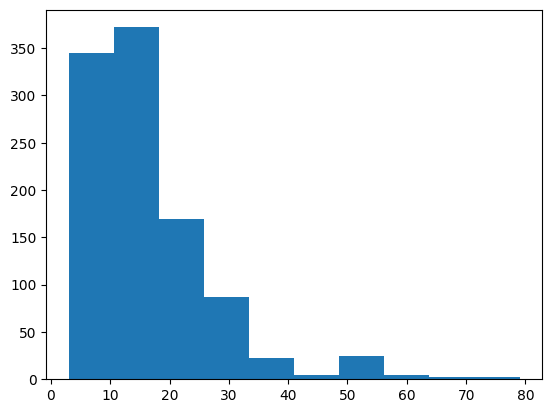

In [92]:
import sqlite3
schema_tables = []
sql_word_cnt = []
superset_cnt = 0
l = LogReader('/mnt/text2sql/meta-prompter-log/schema-data-zero-shot')
for idx, log in enumerate(l.jsons['combined.json']):
    db_id = log['schema']['database']
    question = log['question']
    ground_truth_sql = log['solution']
    predicted_sql = log['normalizeResult']['normalizedSolution'][0]
    
    ##############################
    schema_tables.append(log['schema']['num_tables'])
    sql_word_cnt.append(len(ground_truth_sql.split(' ')))

import numpy as np
import matplotlib.pyplot as plt
plt.hist(sql_word_cnt,)

# Value errors

In [29]:
dev_set = json.load(open('/mnt/text2sql/dataset/spider/dev.json'))
wrong_values = []


for idx, test_query in enumerate(l.jsons['combined.json']):
    original_dev_query = dev_set[test_query['index']]
    values = [v for v, j in zip(original_dev_query['query_toks'], original_dev_query['query_toks_no_value']) if j=='value']
    predicted_tokens = test_query['solution'].replace('\n', ' ').replace(';', ' ').split(' ')
    if not set(values).issubset(set(predicted_tokens)) and not test_query['metrics']['executionMatch']:
        print('Groundtruth values', values)
        print('Predicted values', predicted_tokens)
        wrong_values.append(idx)
    # print(test_query['metrics'])
    # break

Groundtruth values [';']
Predicted values ['SELECT', 't1.cylinders', 'FROM', 'cars_data', 'AS', 't1', 'JOIN', 'car_names', 'AS', 't2', 'ON', 't1.id', '=', 't2.makeid', 'WHERE', 't2.model', '=', "'volvo'", 'ORDER', 'BY', 't1.accelerate', 'ASC', 'LIMIT', '1', '']
Groundtruth values [';']
Predicted values ['SELECT', 't1.cylinders', 'FROM', 'cars_data', 'AS', 't1', 'JOIN', 'car_names', 'AS', 't2', 'ON', 't1.id', '=', 't2.makeid', 'WHERE', 't2.model', '=', "'volvo'", 'ORDER', 'BY', 't1.accelerate', 'ASC', 'LIMIT', '1', '']
Groundtruth values ['1']
Predicted values ['SELECT', 'count(*)', 'FROM', 'cars_data', 'WHERE', 'accelerate', '>', '', '', '', '', '(SELECT', 'accelerate', '', '', '', '', '', 'FROM', 'cars_data', '', '', '', '', '', 'ORDER', 'BY', 'horsepower', 'DESC', '', '', '', '', '', 'LIMIT', '1)', '']
Groundtruth values ['1']
Predicted values ['SELECT', 'count(*)', 'FROM', 'cars_data', 'WHERE', 'accelerate', '>', '', '', '', '', '(SELECT', 'accelerate', '', '', '', '', '', 'FROM', '

In [30]:
len(wrong_values)

33

# Analyze gpt-based results on WikiTQ

In [53]:
import json
# logs = json.load(open('./dataset/WikiTableQuestions/results/GptAnswer_fewShot_demoNum0_atIndexNone_results_pristine-unseen-tables.json', 'r'))
# logs = json.load(open('./dataset/WikiTableQuestions/results/CodexAnswer_fewShot_demoNum0_atIndexNone_results_pristine-unseen-tables.json', 'r'))
# logs = json.load(open('./dataset/WikiTableQuestions/results/CodexSQL_fewShot_demoNum0_atIndexNone_results_pristine-unseen-tables.json', 'r'))
# logs = json.load(open('./dataset/WikiTableQuestions/results/GptAnswer_davinci-codex-002-msft_fewShot_top3cos_results_pristine-unseen-tables.json', 'r'))
# logs = json.load(open('./dataset/WikiTableQuestions/results/GptAnswer_text-davinci-002_fewShot_top3cos_results_pristine-unseen-tables.json', 'r'))
# logs = json.load(open('./dataset/WikiTableQuestions/results/CodexAnswerReason_results_pristine-unseen-tables.json', 'r'))
logs = json.load(open('./dataset/WikiTableQuestions/results/GptAnswerReason_results_pristine-unseen-tables.json', 'r'))

execution_match_cnt = 0
execution_err_cnt = 0
gpt_error = 0

for i, q in enumerate(logs):
    if 'execution_match' in q and q['execution_match']==True:
        execution_match_cnt += 1
    if 'execution_err' in q and q['execution_err'] is not None:
        execution_err_cnt += 1
    if 'gpt_error' in q and q['gpt_error'] is not None:
        gpt_error += 1
        # print(i)
        if gpt_error == 1:
            print(q['gpt_error'])
    # if 'target_value' in q and q['predicted_value'] is not None and q['target_value'] != q['predicted_value'] and q['target_value'] in q['predicted_value']:
    #     print(f"Prediction: {q['predicted_value']}, target: {q['target_value']}")
print(f"Execution match: {execution_match_cnt/len(logs):.2f}")
print(f"Execution err: {execution_err_cnt/len(logs):.2f}")
if gpt_error > 0:
    print(f"GPT error: {gpt_error/len(logs):.2f}")  

This model's maximum context length is 4097 tokens, however you requested 7496 tokens (7368 in your prompt; 128 for the completion). Please reduce your prompt; or completion length.
Execution match: 0.37
Execution err: 0.00
GPT error: 0.02


In [54]:
predictions = ''
for q in logs:
    qid = q['id'].replace(' ', '')
    if 'predicted_value' in q:
        result = str(q['predicted_value']).replace('\n', ' ').replace('\t', ' ')
    else:
        result = ''
    predictions += f"{qid}\t{result}\n"
with open(f'./dataset/WikiTableQuestions/results/temp_predictions.tsv', 'w') as g:
    g.write(predictions)

import subprocess
out = subprocess.check_output(['python2', './dataset/WikiTableQuestions/validate-and-evaluate.py', 
                               '-d', './dataset/WikiTableQuestions/', 
                               '-o', './dataset/WikiTableQuestions/results/output.json',
                               'test', 
                               f'./dataset/WikiTableQuestions/results/temp_predictions.tsv'])
print(out)
_ = os.system('rm ./dataset/WikiTableQuestions/results/temp_predictions.tsv')

b'Dataset version: "Version 1.0.2 (October 4, 2016)"\nusing test split: pristine-unseen-tables.tsv\nReading split file:  pristine-unseen-tables.tsv\nRead 4344 example IDs\nExample ids:  [\'nu-0\', \'nu-1\', \'nu-2\', \'nu-3\', \'nu-4\', \'nu-5\', \'nu-6\', \'nu-7\', \'nu-8\', \'nu-9\']\nUsing prediction file:  ./dataset/WikiTableQuestions/results/temp_predictions.tsv\nReading dataset from ./dataset/WikiTableQuestions/tagged/data/training.tagged\nReading dataset from ./dataset/WikiTableQuestions/tagged/data/pristine-seen-tables.tagged\nReading dataset from ./dataset/WikiTableQuestions/tagged/data/pristine-unseen-tables.tagged\nRead 22033 examples\nReading predictions from ./dataset/WikiTableQuestions/results/temp_predictions.tsv\nExamples: 4344\nCorrect: 3\nAccuracy: 0.0007\n\n'


# Which have exact values from table:

In [61]:
import pandas as pd
df = pd.read_csv(f'./dataset/WikiTableQuestions/data/pristine-unseen-tables.tsv', sep='\t', on_bad_lines='warn')
df

,id,utterance,context,targetValue
0,nu-0,which country had the most cyclists finish wit...,csv/203-csv/733.csv,Italy
1,nu-1,how many people were murdered in 1940/41?,csv/204-csv/149.csv,"100,000"
2,nu-2,how long did it take for the new york american...,csv/203-csv/435.csv,17 years
3,nu-3,alfie's birthday party aired on january 19. wh...,csv/204-csv/803.csv,"January 26, 1995"
4,nu-4,what is the number of 1st place finishes acros...,csv/204-csv/272.csv,17
...,...,...,...,...
4339,nu-4339,what is the total amount of attendance from ga...,csv/203-csv/575.csv,5532
4340,nu-4340,"how many drivers are listed as ""did not qualif...",csv/204-csv/953.csv,5
4341,nu-4341,who was the only person from the us to earn le...,csv/204-csv/900.csv,Bob Tway
4342,nu-4342,how long did it take the 5th place swimmer to ...,csv/204-csv/65.csv,43.12


In [85]:
def df_contain_value():
    pass

exact_value_ids = []
exact_value_qids = []
exact_value_utterances = []
for i in range(df.shape[0]):
    source_df_file = df.iloc[i]['context']
    target_value = df.iloc[i]['targetValue']
    try:
        source_df = pd.read_csv('./dataset/WikiTableQuestions/' + source_df_file, on_bad_lines='skip')
        if source_df.isin([target_value]).any().any() or source_df.isin([target_value.lower()]).any().any():
            exact_value_ids.append(i)
            exact_value_qids.append(df.iloc[i]['id'])
            exact_value_utterances.append(df.iloc[i]['utterance'])
    except:
        pass

In [119]:
exact_value_df = df.loc[exact_value_ids]
# exact_value_df.to_csv(f'./dataset/WikiTableQuestions/data/pristine-unseen-tables-exact-exist.tsv', sep='\t', index=False)

In [122]:
res[0]

{'question': 'which country had the most cyclists finish within the top 10?',
 'solution': 'Italy',
 'schema': {'path': 'csv/203-csv/733.csv',
  'table': [{'Rank': '1',
    'Cyclist': 'Alejandro Valverde (ESP)',
    'Team': "Caisse d'Epargne",
    'Time': '5h 29\' 10"',
    'UCI ProTour\nPoints': '40'},
   {'Rank': '2',
    'Cyclist': 'Alexandr Kolobnev (RUS)',
    'Team': 'Team CSC Saxo Bank',
    'Time': 's.t.',
    'UCI ProTour\nPoints': '30'},
   {'Rank': '3',
    'Cyclist': 'Davide Rebellin (ITA)',
    'Team': 'Gerolsteiner',
    'Time': 's.t.',
    'UCI ProTour\nPoints': '25'},
   {'Rank': '4',
    'Cyclist': 'Paolo Bettini (ITA)',
    'Team': 'Quick Step',
    'Time': 's.t.',
    'UCI ProTour\nPoints': '20'},
   {'Rank': '5',
    'Cyclist': 'Franco Pellizotti (ITA)',
    'Team': 'Liquigas',
    'Time': 's.t.',
    'UCI ProTour\nPoints': '15'},
   {'Rank': '6',
    'Cyclist': 'Denis Menchov (RUS)',
    'Team': 'Rabobank',
    'Time': 's.t.',
    'UCI ProTour\nPoints': '11'},
   {

In [125]:
res = json.load(open('/mnt/text2sql/meta-prompter-log/wiki-tq/1670176301892/combined.json', 'r'))
executionMatches = 0

valueExists = []
correct_predictions = []
predcition_values = []
for i, r in enumerate(res):
    predcition_values.append(r['normalizeResult']['normalizedSolution'][0])
    
    if r['question'].lower() in exact_value_utterances:
        valueExists.append(True)
    else:
        valueExists.append(False)
    
    if r['metrics']['executionMatch'] or r['metrics']['exactMatch']:
        correct_predictions.append(True)
    else:
        correct_predictions.append(False)
        
            

In [95]:
executionMatches / len(exact_value_ids)

0.002081165452653486

In [126]:
df['valueExistsInCsv'] = valueExists
df['gptPrediction'] = predcition_values
df['gptQuality'] = correct_predictions
df.to_csv(f'./dataset/WikiTableQuestions/data/pristine-unseen-tables-analyze.tsv', sep='\t', index=False)

In [ ]:
relative_pos_keywords = ['after', 'before', 'rank', 'next', 'previous', 'last', 'first', 'most', 'least', 'same', 'more', 'less']

# Majority vote

# Which program used python

In [3]:
import json
res = json.load(open('/mnt/text2sql/dataset/WikiTableQuestions/results/CodexAnswerCOTExecutor_sql-py_results_pristine-unseen-tables.json', 'r'))


In [9]:
for q in res[:100]:
    if 'gpt_original_output' in q:
        for prediction in q['gpt_original_output']:
            if 'Python:' in prediction:
                print(q['id'], q['gpt_error'])
                break

nu-5 None
nu-6 Cannot execute Python DF['language'] = DF.apply(lambda x: x['language'].lower(), axis=1) on 
    year                       film       role language                                                                                                                          notes
0   2008             Moggina Manasu  Chanchala  Kannada                                         Filmfare Award for Best Actress - Kannada\nKarnataka State Film Award for Best Actress
1   2009  Olave Jeevana Lekkachaara    Rukmini  Kannada                                                                                         Innovative Film Award for Best Actress
2   2009                  Love Guru      Kushi  Kannada                                                                                      Filmfare Award for Best Actress - Kannada
3   2010        Krishnan Love Story     Geetha  Kannada                                                        Filmfare Award for Best Actress - Kannada\nUdaya 

# my own evaluator

In [154]:
# Todo: dataframe trace-back
# Todo: analyze the results see which is not good 

import json
def evaluator(filename):
    error_idx = []
    logs = json.load(open(filename))
    total_cnt = len(logs)
    correct_cnt = 0
    error_cnt = 0
    for i, l in enumerate(logs):
        if 'target_value' in l and l['target_value'] == l['predicted_value']:
            correct_cnt += 1
        else:
            # print(i)
            error_idx.append(i)
            pass
        if 'gpt_error' in l and l['gpt_error'] is not None:
            print(i)
            error_cnt += 1
    print("error:", error_cnt)
    error_logs = [logs[i] for i in error_idx]
    return correct_cnt / total_cnt, error_logs

acc, err_logs = evaluator('/mnt/text2sql/dataset/Table-Fact-Checking/results/CodexAnswerCOTExecutor_sql_results_test_small.json')
print("Accuracy: ", acc)
# json.dump(err_logs, open('/mnt/text2sql/dataset/Table-Fact-Checking/results/CodexAnswerCOTExecutor_sql_results_test_small_error_logs.json', 'w'))

246
763
1536
1615
1871
1923
1962
error: 7
Accuracy:  0.8388388388388388


In [155]:
acc, err_logs = evaluator('/mnt/text2sql/dataset/Table-Fact-Checking/results/CodexAnswerCOTExecutor_original-sql_sql_NNDemo=False_results_test_small.json')
print("Accuracy: ", acc)

246
1615
1923
1962
error: 4
Accuracy:  0.8348348348348348


In [163]:
acc, err_logs = evaluator('/mnt/text2sql/dataset/Table-Fact-Checking/results/CodexAnswerCOTExecutor_original-sql_sql_NNDemo=True_results_test_small.json')
print("Accuracy: ", acc)

17
140
310
470
488
504
614
763
808
1266
1275
1373
1586
1722
1923
1954
1962
error: 17
Accuracy:  0.8273273273273273


In [11]:
# logs = json.load(open('/mnt/GPT-TabQA/dataset/WikiTableQuestions/results/CodexAnswerCOTExecutor_original-sql-py-no-intermediate_sql-py_NNDemo=False_results_pristine-unseen-tables_limitinf_modelmp-aoi-codex.json'))
logs = json.load(open('/mnt/GPT-TabQA/dataset/WikiTableQuestions/results/CodexAnswerCOTExecutor_LeverVote_original-sql-py-no-intermediate_sql-py_NNDemo=False_results_pristine-unseen-tables_limitinf_modelmp-aoi-codex.json'))
# logs = json.load(open('/mnt/text2sql/dataset/Table-Fact-Checking/results/CodexAnswerCOTExecutor_formatv1_sql_results_test_small.json'))
print(logs[15]['prompt']) 

# put question before table? 
# COT on the answers

# logs[80].keys()

The database table DF is shown as follows:
[HEAD]: name|c_1989|c_1990|c_1991|c_1992|c_1993|c_1994|c_1995|c_1996|c_1997|c_1998|c_1999|c_2000|c_2001|c_2002|c_2003|c_2004|c_2005|c_2006|c_2007|c_2008|c_2009|c_2010|career_sr|career_win_loss
---
[ROW] 1: Australian Open|A|A|1R|A|2R|3R|2R|1R|A|3R|4R|1R|2R|1R|3R|2R|1R|QF|3R|2R|3R|1R|0 / 18|22–18
[ROW] 2: French Open|1R|2R|4R|1R|1R|3R|1R|A|1R|3R|1R|2R|4R|2R|2R|3R|1R|1R|1R|2R|1R|A|0 / 20|17–20
[ROW] 3: Wimbledon|A|1R|A|A|A|A|1R|A|1R|A|2R|2R|3R|2R|2R|2R|2R|2R|2R|1R|2R|A|0 / 14|11–14
...
[ROW] 17: Annual Win-Loss|nan|2–4|7–5|3–5|6–4|2–1|5–4|2–1|12–6|10–9|10–7|12–9|13–9|9–9|2–7|8–5|7–7|3–8|4–3|2–3|1–2|0–0|nan|120–108
[ROW] 18: Year End Ranking|235|62|43|43|55|46|102|118|29|41|34|31|22|35|62|52|58|52|37|52|68|–|nan|nan

Answer the following question based on the data above: "did he win more at the australian open or indian wells?". Generate SQL or Python code step-by-step given the question and table to answer the question correctly. For each step, 

In [12]:
logs = json.load(open('/mnt/GPT-TabQA/dataset/WikiTableQuestions/results/CodexAnswerCOTExecutor_original-sql-py-no-intermediate_sql-py_NNDemo=False_results_pristine-unseen-tables_limitinf_modelmp-aoi-codex.json'))
# logs = json.load(open('/mnt/GPT-TabQA/dataset/WikiTableQuestions/results/CodexAnswerCOTExecutor_LeverVote_original-sql-py-no-intermediate_sql-py_NNDemo=False_results_pristine-unseen-tables_limitinf_modelmp-aoi-codex.json'))
# logs = json.load(open('/mnt/text2sql/dataset/Table-Fact-Checking/results/CodexAnswerCOTExecutor_formatv1_sql_results_test_small.json'))
print(logs[15]['prompt']) 

# put question before table? 
# COT on the answers

# logs[80].keys()

The database table DF is shown as follows:
[HEAD]: name|c_1989|c_1990|c_1991|c_1992|c_1993|c_1994|c_1995|c_1996|c_1997|c_1998|c_1999|c_2000|c_2001|c_2002|c_2003|c_2004|c_2005|c_2006|c_2007|c_2008|c_2009|c_2010|career_sr|career_win_loss
---
[ROW] 1: Australian Open|A|A|1R|A|2R|3R|2R|1R|A|3R|4R|1R|2R|1R|3R|2R|1R|QF|3R|2R|3R|1R|0 / 18|22–18
[ROW] 2: French Open|1R|2R|4R|1R|1R|3R|1R|A|1R|3R|1R|2R|4R|2R|2R|3R|1R|1R|1R|2R|1R|A|0 / 20|17–20
[ROW] 3: Wimbledon|A|1R|A|A|A|A|1R|A|1R|A|2R|2R|3R|2R|2R|2R|2R|2R|2R|1R|2R|A|0 / 14|11–14
...
[ROW] 17: Annual Win-Loss|nan|2–4|7–5|3–5|6–4|2–1|5–4|2–1|12–6|10–9|10–7|12–9|13–9|9–9|2–7|8–5|7–7|3–8|4–3|2–3|1–2|0–0|nan|120–108
[ROW] 18: Year End Ranking|235|62|43|43|55|46|102|118|29|41|34|31|22|35|62|52|58|52|37|52|68|–|nan|nan

Answer the following question based on the data above: "did he win more at the australian open or indian wells?". Generate SQL or Python code step-by-step given the question and table to answer the question correctly. For each step, 

In [4]:
import json

logs = json.load(open('/Users/yunjia/Dropbox/GSL@Microsoft/LM_semantics/GPT-TabQA/dataset/Table-Fact-Checking/tmp_results/CodexAnswerCOTExecutor_original-sql-py-no-intermediate-v1-with-title_sql-py_NNDemo=False_results_small_test_new_tmTrue_portion0_modelcode-davinci-002.json'))

correct_cnt = 0
error_cnt = 0
for i, l in enumerate(logs):
    if 'predicted_value' in l:
        if l['target_value'] == l['predicted_value']:
            correct_cnt += 1
        # elif len(l['all_predictions_with_error']) != 0:
        #     error_cnt += 1
        #     pass
        else:
            print(f"{i}, {logs[i]['id']}, {logs[i]['utterance'][:100]}")
            pass
    else:
        error_cnt += 1

print(f"Acc = {correct_cnt} / {len(logs)} = {correct_cnt / len(logs)}")
print(f"Error: {error_cnt} / {len(logs)} = {error_cnt / len(logs)}")


26, 26, a majority of the people who score over par be from the united state
30, 30, except for slovakia , all other country be from north america
35, 35, the only player not from the united state or canada be from norway
37, 37, every player come from either a college program or a junior / club team
38, 38, 2 player be draft in each round round 3 and 9
39, 39, triston grant play the same position as the other payer draft in his round
42, 42, west berkshire brewery 's maggs magnificent mild be its most decorate beer between 1995 and 2009
46, 46, west berkshire brewery 's dr hexter healer beer have only receive a silver medal between 1995 and 20
49, 49, 3 of the game at the us airways center have the same attendance
50, 50, the highest attendance be at the american airline center
59, 59, emi watanabe be rank 1 place higher than dagmar lurz in the 1979 world figure skate championship
60, 60, there be a 74.64 point difference between the highest score (186.92) and the lowest score (112.28

In [ ]:
5, 604, in the 2005 milwaukee brewer season be attend by more than 30000 crowd for every game - # select count(*)=(select count(*) from df) where attendance>30000;

15, 614, the most highly attended game be against minnesota at the prudential center
23, 622, phil mickelson be the the only player from united state
24, 623, frank nobilo be the only player from zimbabwe
28, 627, there be 2 zakspeed chassis make in the year 1987
36, 635, the top 2 team have the same number of point but separate by a goal difference
39, 638, 3 team tie on point but be separate by goal difference
44, 643, none team tie on point , but most be separate by more than 1 goal difference
46, 645, melbourne be the team with the highest away team score
49, 648, kardinia park be 1 of 2 venue where the home team score be higher than the away team score
51, 650, fitzroy be the team with the highest away team score
62, 661, 斤 and 担 / 擔 both have the same relative value
64, 663, 錢 and 斤 be the only character that have metric value measure in g
65, 664, manchester unite have be 2nd in league position since 17 november 2005
66, 665, manchester unite have beat portsmouth 2 out of 2 time since 13 august 2005
67, 666, manchester unite have lose to the blackburn rover 2 out of 2 time since 13 august 2005
71, 670, manchester unite have draw all mathces to the blackburn rover 2 out of 2 time since 13 august 2005
73, 672, the last game of the season happen on 11 february 2006
75, 674, all game in the 2006 season be play in the month of sep
79, 678, in the 2006 season the texas mariner play the angel 9 time
82, 681, the texas mariner play the tiger 2 time in the 2008 season
89, 688, gary and allison brook be the episode with the least amount of viewer
94, 693, the boston celtic only lose 3 game in the 1984 - 85 season
95, 694, the new york knicks do not win a game against the boston celtic in the 1984 - 85 season

In [ ]:
# add semantics : only
# wrong groundtruth 627
